## Introduction

In the 4th laboratory excercsise for the subject Machine Learning, the goal is to try to use different techniques used throughout the course. In this excercise, the 2 datasets are divided into Regression problems and Classification problem. For this lab, I chose to follow the goal of creating a solution for the Regression problem, thus working with the Forest Fires dataset.

The goal of the Forest Fires dataset is to predict the burned area of the forests in northeast region of Portugal, based on the variables given from spatial, temporal and weather perspective where the fire is spotted. This relevant information was provided using metereological data.

###### The target is the area burnt from fires

In [1]:
target = 'area'     

# 1. Importing required libraries

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import statsmodels.api as sm
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from scipy.stats import zscore
from statsmodels.stats.stattools import durbin_watson
from sklearn.model_selection import train_test_split,KFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression,RidgeCV,LassoCV,ElasticNetCV

# 2. Loading the Forest Fires Dataset

In [4]:
df = pd.read_csv("forestfires.csv")
df.shape

(517, 13)

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
X,517.0,4.669246,2.313778,1.0,3.0,4.00,7.00,9.00
Y,517.0,4.299807,1.229900,2.0,4.0,4.00,5.00,9.00
FFMC,517.0,90.644681,5.520111,18.7,90.2,91.60,92.90,96.20
DMC,517.0,110.872340,64.046482,1.1,68.6,108.30,142.40,291.30
DC,517.0,547.940039,248.066192,7.9,437.7,664.20,713.90,860.60
ISI,517.0,9.021663,4.559477,0.0,6.5,8.40,10.80,56.10
temp,517.0,18.889168,5.806625,2.2,15.5,19.30,22.80,33.30
RH,517.0,44.288201,16.317469,15.0,33.0,42.00,53.00,100.00
wind,517.0,4.017602,1.791653,0.4,2.7,4.00,4.90,9.40
rain,517.0,0.021663,0.295959,0.0,0.0,0.00,0.00,6.40


In [7]:
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [8]:
df.dtypes

X          int64
Y          int64
month     object
day       object
FFMC     float64
DMC      float64
DC       float64
ISI      float64
temp     float64
RH         int64
wind     float64
rain     float64
area     float64
dtype: object

# 3. Visualization and Exploratory Data Analys

In [9]:
plt.rcParams["figure.figsize"] = 9,5

##### 3.1 Univariate analysis

Skew: 12.846933533934868
Kurtosis: 194.1407210942299


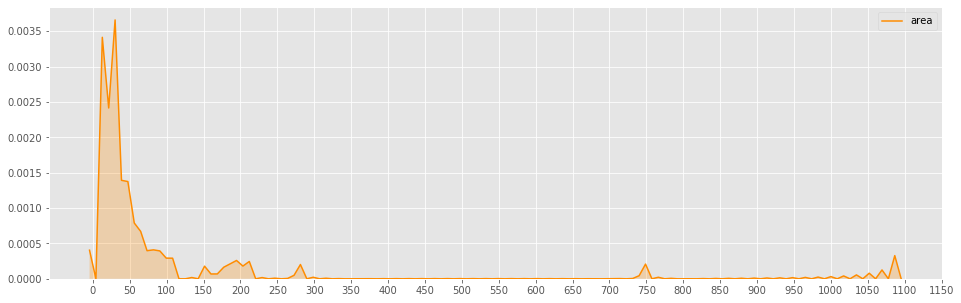

In [12]:
plt.figure(figsize=(16,5))
print("Skew: {}".format(df[target].skew()))
print("Kurtosis: {}".format(df[target].kurtosis()))
ax = sns.kdeplot(df[target],shade=True,color='darkorange')
plt.xticks([i for i in range(0,1200,50)])
plt.show()

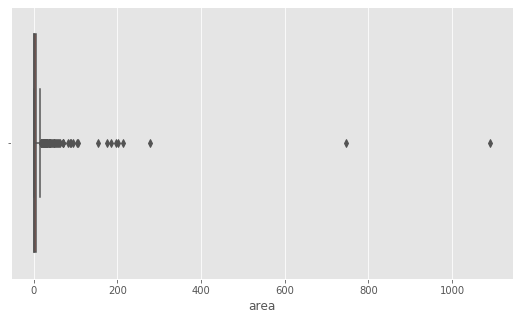

In [13]:
ax = sns.boxplot(df[target])

###### Some observations:

The data is highly skewed with a value of +12.84 and huge kurtosis value of 194.

It even tells you that majority of the forest fires do not cover a large area, most of the damaged area is under 50 hectares of land.

We can apply tranformation to fix the skewnesss and kurtosis, however we will have to inverse transform before submitting the output.

Outlier Check: There are 4 outlier instances in our area columns but the questions is should we drop it or not? (Will get back to this in the outlier treatment step)

In [14]:
# Outlier points
y_outliers = df[abs(zscore(df[target])) >= 3 ]
y_outliers

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
237,1,2,sep,tue,91.0,129.5,692.6,7.0,18.8,40,2.2,0.0,212.88
238,6,5,sep,sat,92.5,121.1,674.4,8.6,25.1,27,4.0,0.0,1090.84
415,8,6,aug,thu,94.8,222.4,698.6,13.9,27.5,27,4.9,0.0,746.28
479,7,4,jul,mon,89.2,103.9,431.6,6.4,22.6,57,4.9,0.0,278.53


##### Independent columns

In [21]:
dfa = df.drop(columns=target)
cat_columns = dfa.select_dtypes(include='object').columns.tolist()
num_columns = dfa.select_dtypes(exclude='object').columns.tolist()

cat_columns,num_columns

(['month', 'day'],
 ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain'])

##### Numerical columns

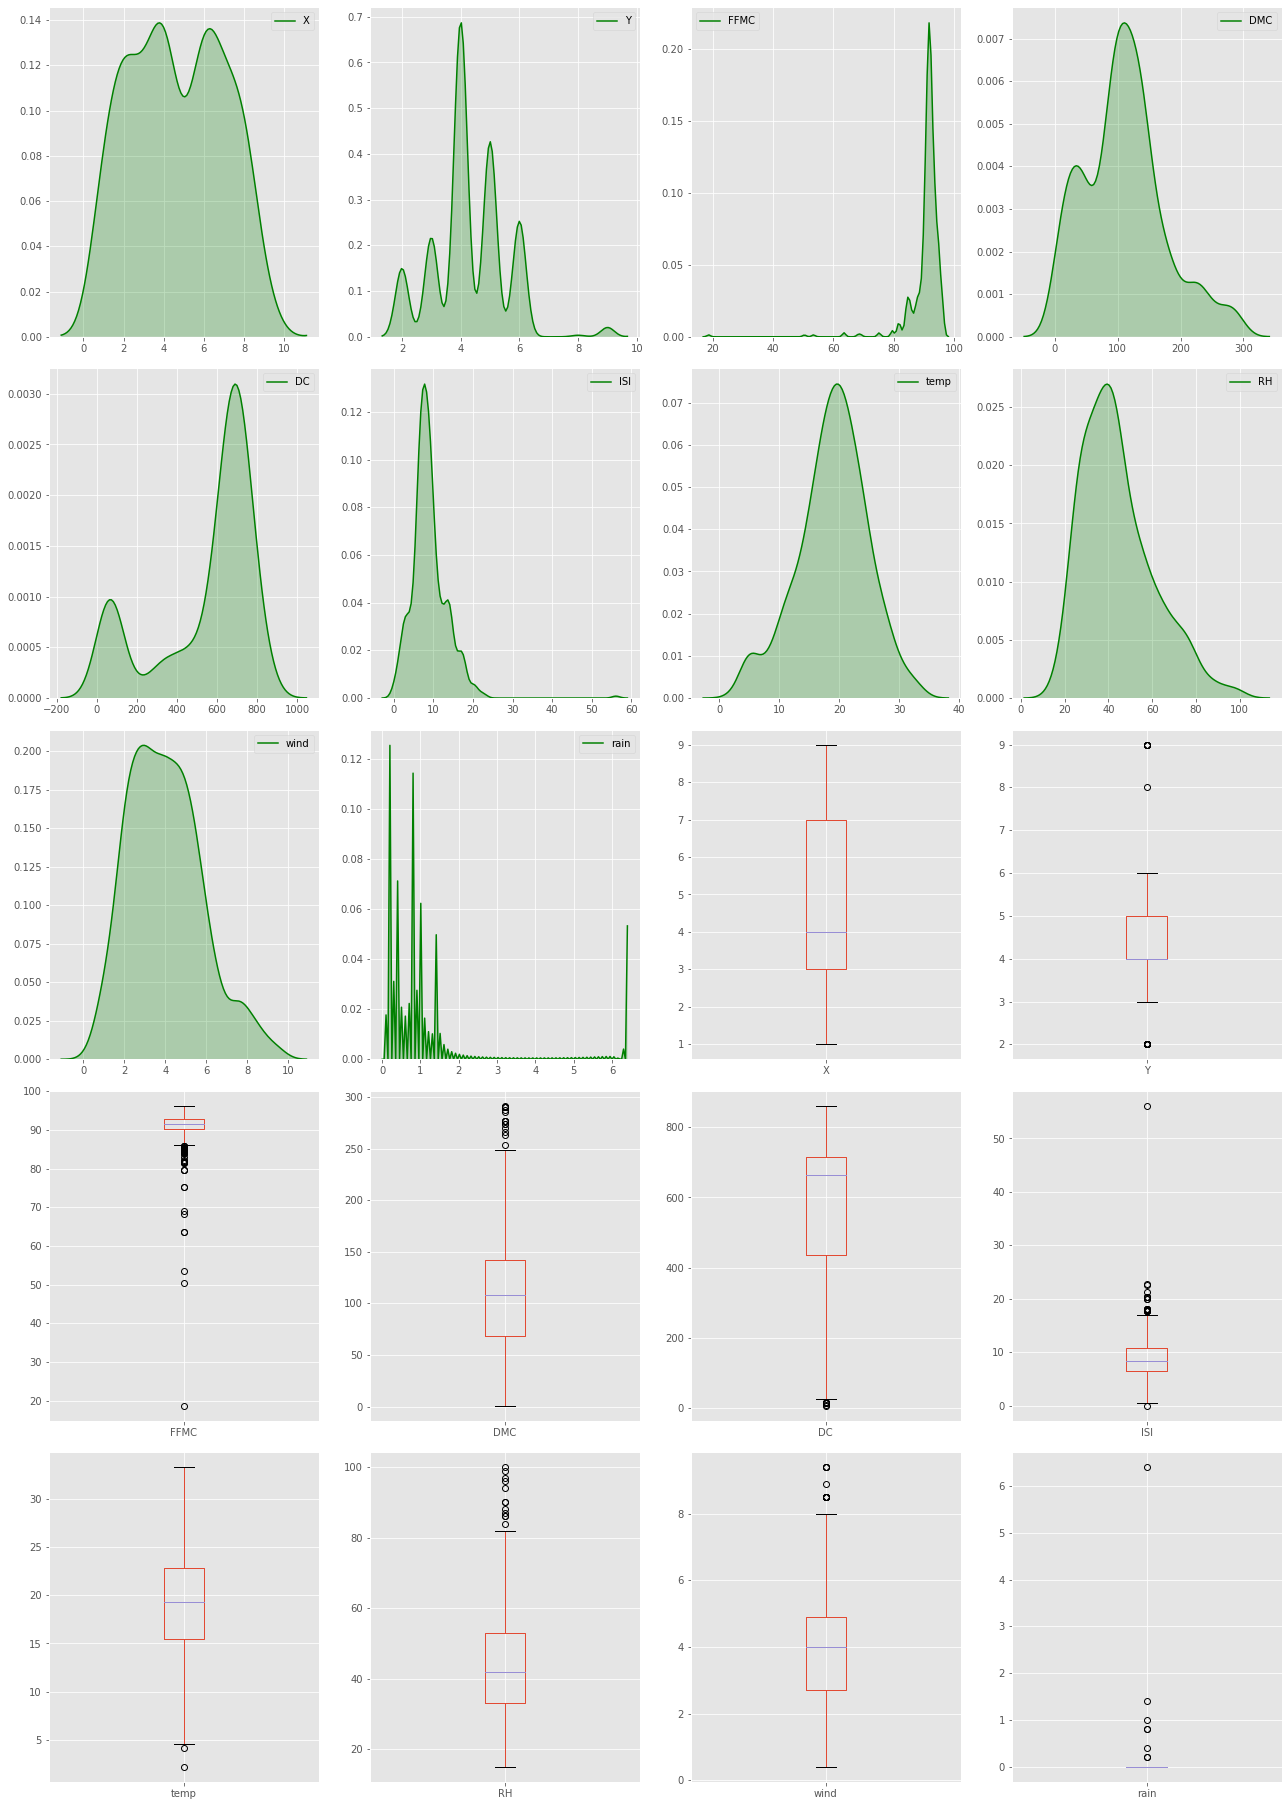

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain
skewness,0.036246,0.417296,-6.575606,0.547498,-1.100445,2.536325,-0.331172,0.862904,0.571001,19.816344
kurtosis,-1.172331,1.420553,67.066041,0.204822,-0.245244,21.458037,0.136166,0.438183,0.054324,421.295964


In [22]:
plt.figure(figsize=(18,40))
for i,col in enumerate(num_columns,1):
    plt.subplot(8,4,i)
    sns.kdeplot(df[col],color='g',shade=True)
    plt.subplot(8,4,i+10)
    df[col].plot.box()
plt.tight_layout() 
plt.show()
num_data = df[num_columns]
pd.DataFrame(data=[num_data.skew(),num_data.kurtosis()],index=['skewness','kurtosis'])

##### Categorical columns

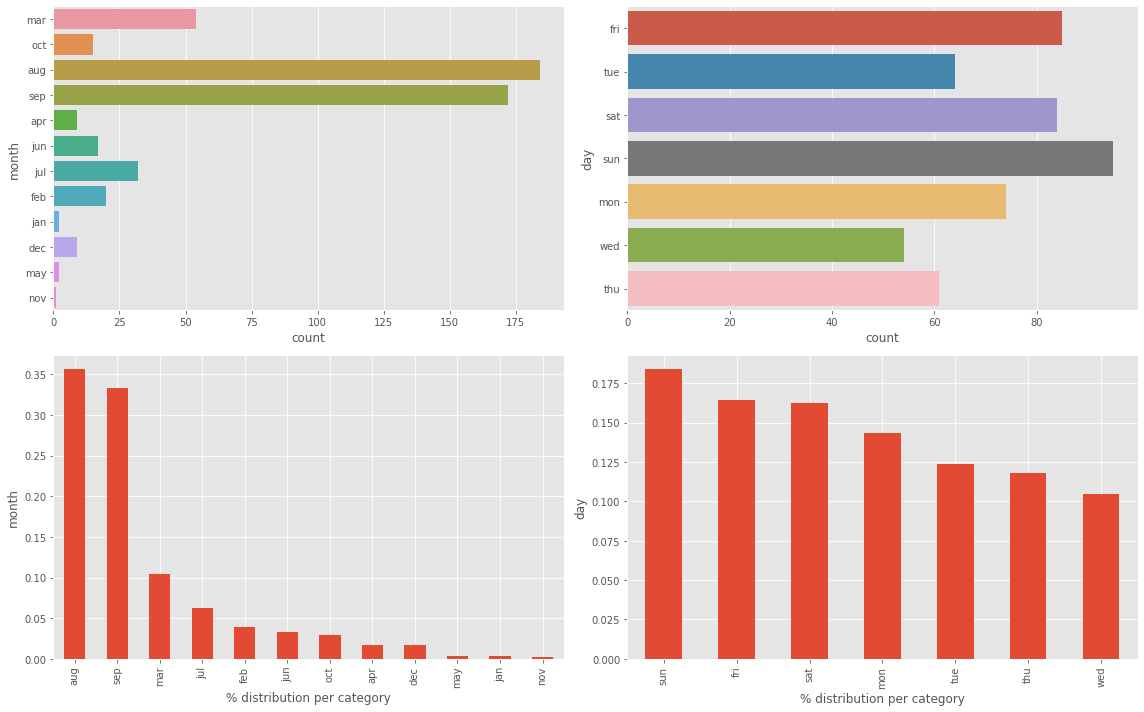

In [23]:
# analyzing categorical columns
plt.figure(figsize=(16,10))
for i,col in enumerate(cat_columns,1):
    plt.subplot(2,2,i)
    sns.countplot(data=dfa,y=col)
    plt.subplot(2,2,i+2)
    df[col].value_counts(normalize=True).plot.bar()
    plt.ylabel(col)
    plt.xlabel('% distribution per category')
plt.tight_layout()
plt.show()    

### Bivariate analysis with the target variable

In [24]:
print(df['area'].describe(),'\n')
print(y_outliers)

count     517.000000
mean       12.847292
std        63.655818
min         0.000000
25%         0.000000
50%         0.520000
75%         6.570000
max      1090.840000
Name: area, dtype: float64 

     X  Y month  day  FFMC    DMC     DC   ISI  temp  RH  wind  rain     area
237  1  2   sep  tue  91.0  129.5  692.6   7.0  18.8  40   2.2   0.0   212.88
238  6  5   sep  sat  92.5  121.1  674.4   8.6  25.1  27   4.0   0.0  1090.84
415  8  6   aug  thu  94.8  222.4  698.6  13.9  27.5  27   4.9   0.0   746.28
479  7  4   jul  mon  89.2  103.9  431.6   6.4  22.6  57   4.9   0.0   278.53


In [25]:
# a categorical variable based on forest fire area damage
# No damage, low, moderate, high, very high
def area_cat(area):
    if area == 0.0:
        return "No damage"
    elif area <= 1:
        return "low"
    elif area <= 25:
        return "moderate"
    elif area <= 100:
        return "high"
    else:
        return "very high"

df['damage_category'] = df['area'].apply(area_cat)
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,damage_category
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,No damage
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,No damage
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,No damage
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,No damage
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,No damage


##### Categorical columns

In [26]:
cat_columns

['month', 'day']

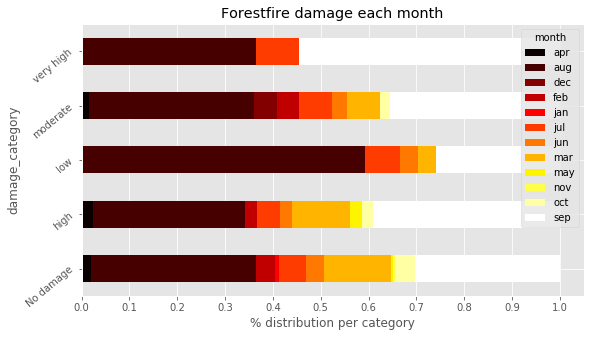

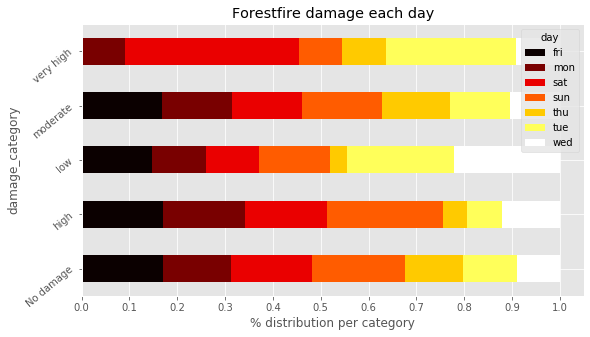

In [27]:
for col in cat_columns:
    cross = pd.crosstab(index=df['damage_category'],columns=df[col],normalize='index')
    cross.plot.barh(stacked=True,rot=40,cmap='hot')
    plt.xlabel('% distribution per category')
    plt.xticks(np.arange(0,1.1,0.1))
    plt.title("Forestfire damage each {}".format(col))
plt.show()

##### Numerical columns

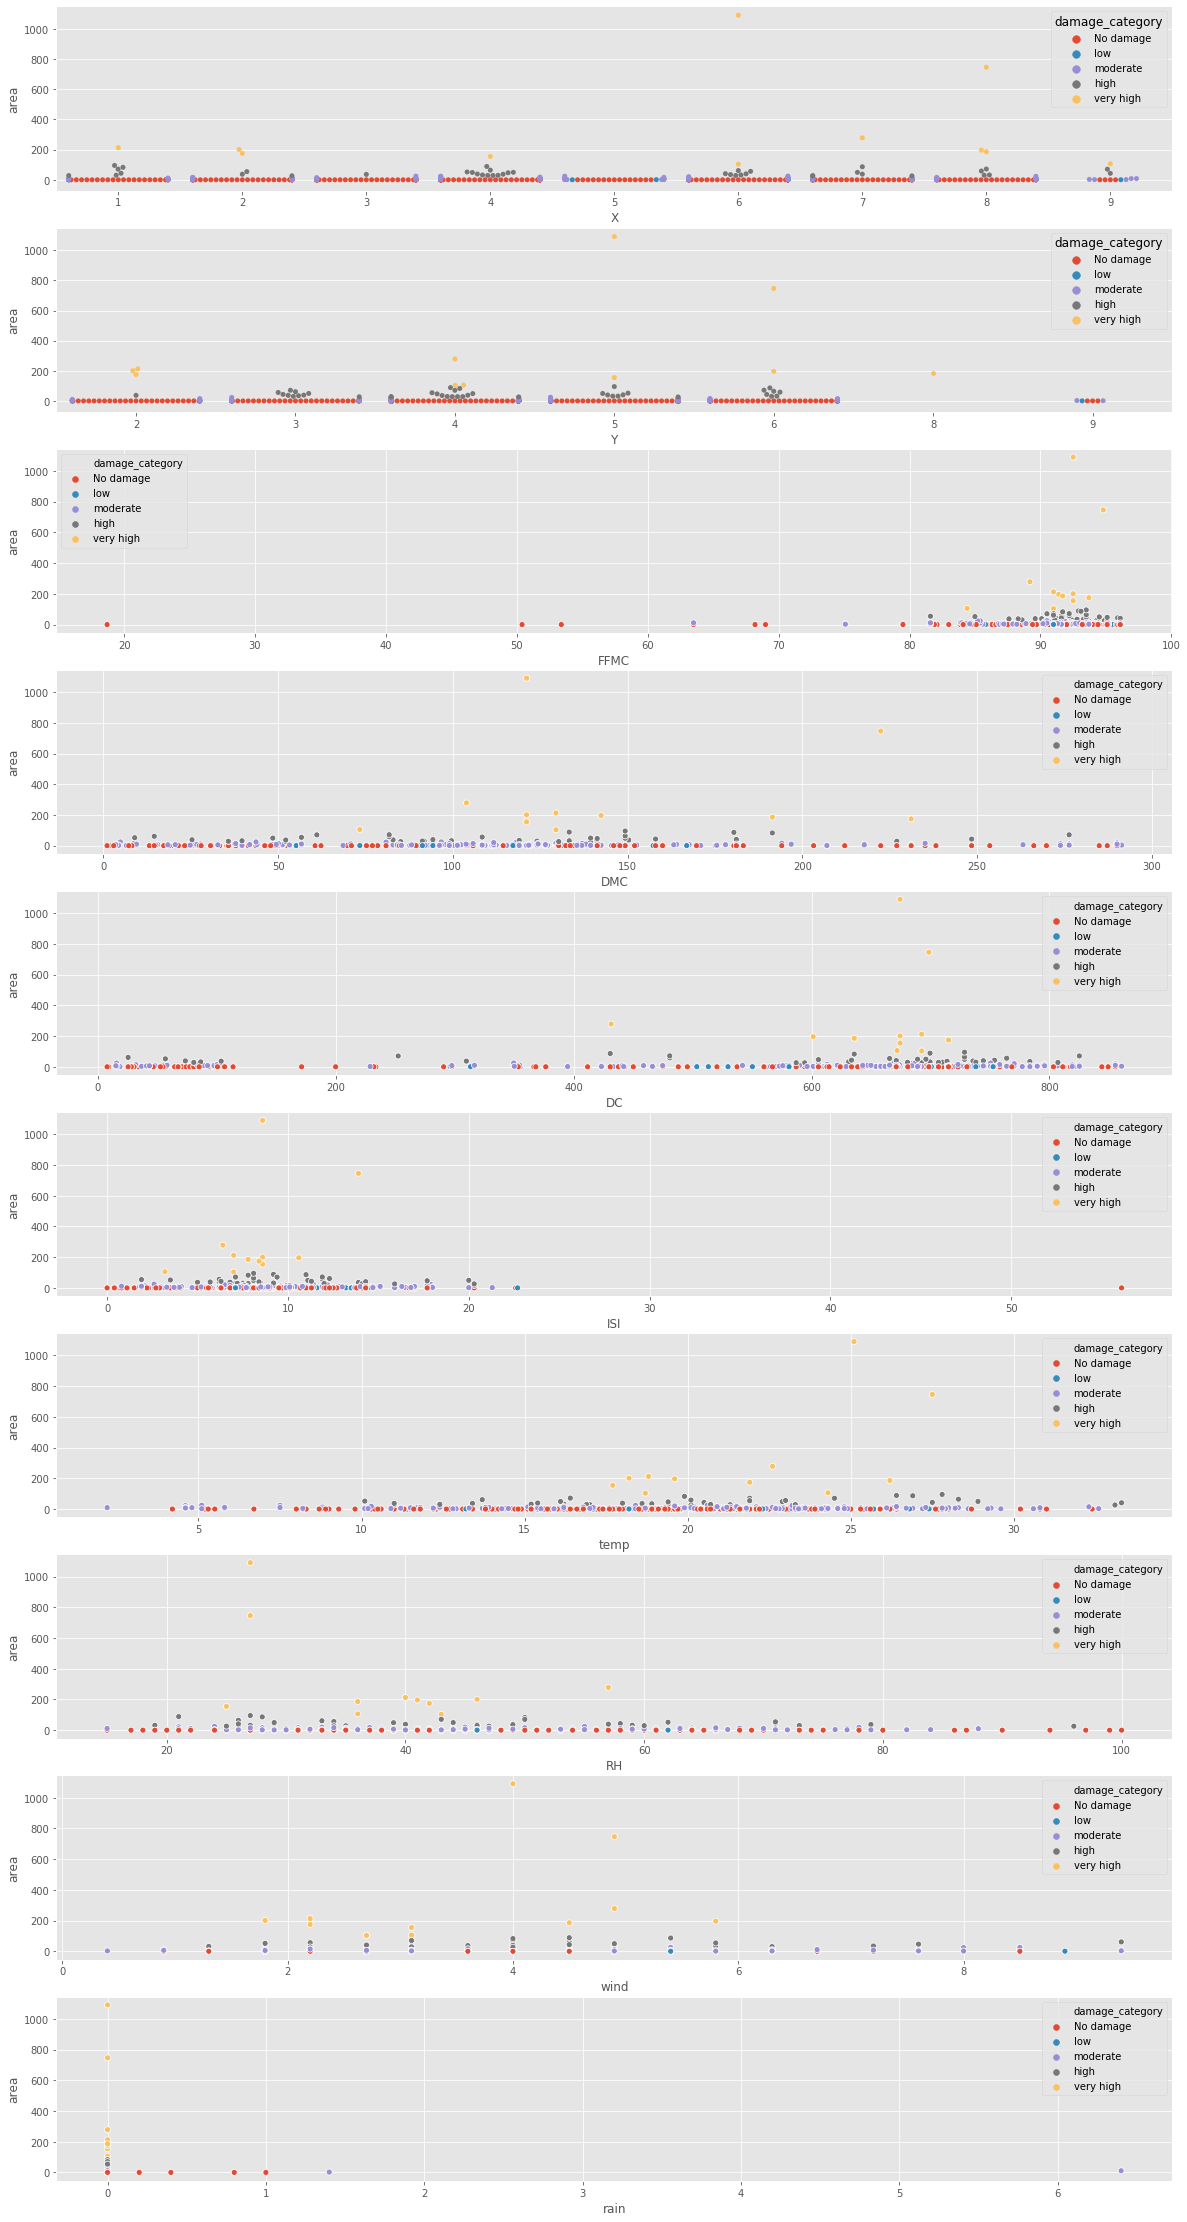

In [28]:
plt.figure(figsize=(20,40))
for i,col in enumerate(num_columns,1):
    plt.subplot(10,1,i)
    if col in ['X','Y']:
        sns.swarmplot(data=df,x=col,y=target,hue='damage_category')
    else:
        sns.scatterplot(data=df,x=col,y=target,hue='damage_category')
plt.show()

#### 3.2 Multivariate analysis

In [29]:
selected_features = df.drop(columns=['damage_category','day','month']).columns
selected_features

Index(['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain',
       'area'],
      dtype='object')

I had observed outliers in the folowing columns:

1. area
2. FFMC
3. ISI
4. rain

In [33]:
out_columns = ['area','FFMC','ISI','rain']

Since they are not error values I cannot remove them, however in order to minimize the effect of outliers in this model i will transform the above features.

### Preparing the data for modelling

In [34]:
df = pd.get_dummies(df,columns=['day','month'],drop_first=True)

In [35]:
print(df[out_columns].describe())
np.log1p(df[out_columns]).skew(), np.log1p(df[out_columns]).kurtosis()

              area        FFMC         ISI        rain
count   517.000000  517.000000  517.000000  517.000000
mean     12.847292   90.644681    9.021663    0.021663
std      63.655818    5.520111    4.559477    0.295959
min       0.000000   18.700000    0.000000    0.000000
25%       0.000000   90.200000    6.500000    0.000000
50%       0.520000   91.600000    8.400000    0.000000
75%       6.570000   92.900000   10.800000    0.000000
max    1090.840000   96.200000   56.100000    6.400000


(area     1.217838
 FFMC   -11.675394
 ISI     -0.937218
 rain    14.173028
 dtype: float64, area      0.945668
 FFMC    185.482383
 ISI       2.584588
 rain    234.240025
 dtype: float64)

In [36]:
# FFMC and rain are still having high skew and kurtosis values, 
# since we will be using Linear regression model we cannot operate with such high values
# so for FFMC we can remove the outliers in them using z-score method
mask = df.loc[:,['FFMC']].apply(zscore).abs() < 3

# Since most of the values in rain are 0.0, we can convert it as a categorical column
df['rain'] = df['rain'].apply(lambda x: int(x > 0.0))

df = df[mask.values]
df.shape

(510, 29)

In [37]:
out_columns.remove('rain')
df[out_columns] = np.log1p(df[out_columns])

In [38]:
df[out_columns].skew()

area    1.208492
FFMC   -1.803993
ISI    -0.434372
dtype: float64

In [40]:
# this dataframe will be used to build the ML model
df_ml = df.drop(columns=['damage_category']).copy()

# 4. Regression

### 4.1 Linear Regression

In [41]:
X = df.drop(columns=['area','damage_category'])
y = df['area']

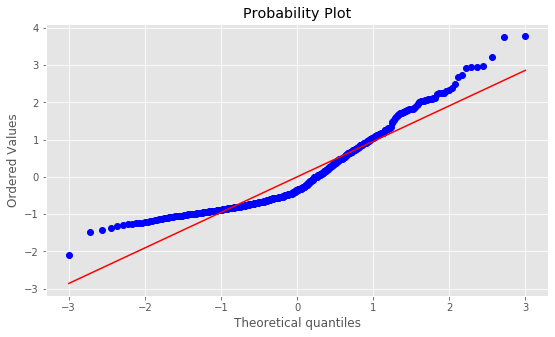

In [43]:
import scipy.stats as stats
import pylab

# get an instance of Influence with influence and outlier measures 
st_resid = lin_reg.get_influence().resid_studentized_internal
stats.probplot(st_resid,dist="norm",plot=pylab)
plt.show()

In [44]:
# return fstat and p-value
sm.stats.diagnostic.linear_rainbow(lin_reg)

(1.2832659161650852, 0.027048891500426695)

Null hypothesis (H0): The Null hypothesis is that the regression is correctly modeled as linear.
Alternate hypothesis(H1): The model is non-linear

#### 4.1.1. Expectation Mean of residual is zero

In [45]:
# The mean expected value around 0, it implies linearity is preserved
lin_reg.resid.mean()

-2.19824158875781e-15

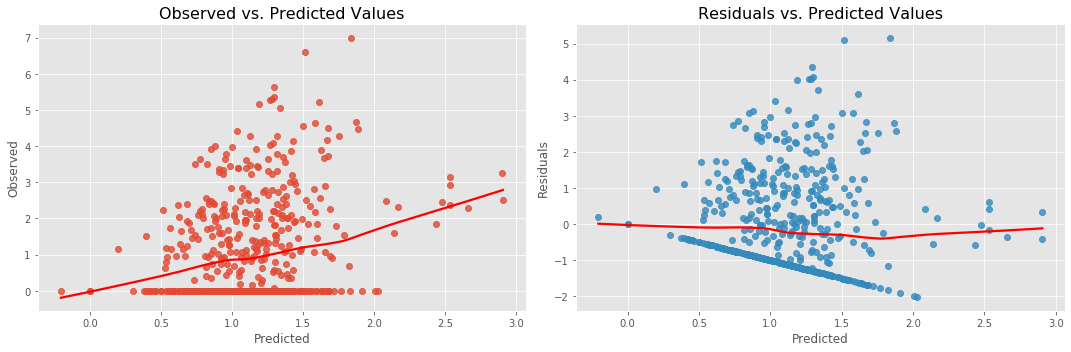

In [46]:
def linearity_test(model, y):
    '''
    Function for visually inspecting the assumption of linearity in a linear regression model.
    It plots observed vs. predicted values and residuals vs. predicted values.
    
    Args:
    * model - fitted OLS model from statsmodels
    * y - observed values
    '''
    fitted_vals = model.predict()
    resids = model.resid

    fig, ax = plt.subplots(1,2,figsize=(15,5))

    sns.regplot(x=fitted_vals, y=y, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Observed vs. Predicted Values', fontsize=16)
    ax[0].set(xlabel='Predicted', ylabel='Observed')

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Residuals vs. Predicted Values', fontsize=16)
    ax[1].set(xlabel='Predicted', ylabel='Residuals')
    
linearity_test(lin_reg, y) 
plt.tight_layout()

##### 4.1.2. Normality of the residuals

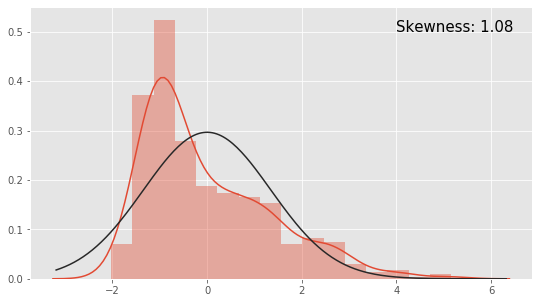

In [48]:
sns.distplot(lin_reg.resid,fit=stats.norm)
plt.text(4,0.5,f"Skewness: {round(lin_reg.resid.skew(),2)}",fontsize=15)
plt.show()

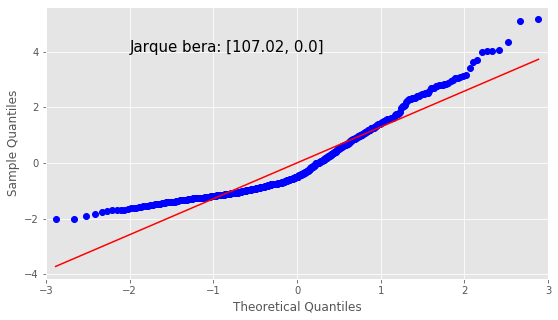

In [49]:
sm.qqplot(lin_reg.resid,line ='r')
jb = [round(n,2) for n in stats.jarque_bera(lin_reg.resid)]
plt.text(-2,4,f"Jarque bera: {jb}",fontsize=15)
plt.show()

##### 4.1.3. Homoscedasticity

In [50]:
sms.het_goldfeldquandt(lin_reg.resid, lin_reg.model.exog)

(0.9005330268628148, 0.7860123901512466, 'increasing')

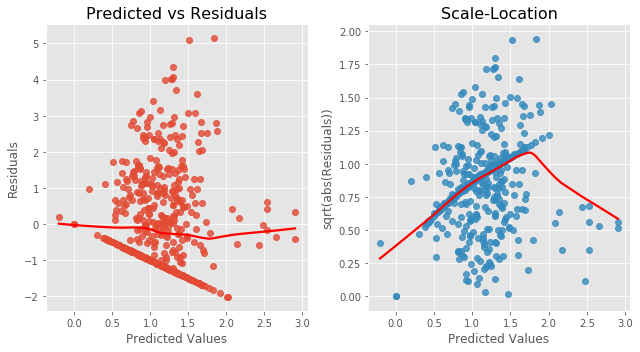

In [51]:
model = lin_reg
fitted_vals = model.predict()
resids = model.resid
resids_standardized = model.get_influence().resid_studentized_internal

fig, ax = plt.subplots(1,2)

sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[0], line_kws={'color': 'red'})
ax[0].set_title('Predicted vs Residuals', fontsize=16)
ax[0].set(xlabel='Predicted Values', ylabel='Residuals')

sns.regplot(x=fitted_vals, y=np.sqrt(np.abs(resids_standardized)), lowess=True, ax=ax[1], line_kws={'color': 'red'})
ax[1].set_title('Scale-Location', fontsize=16)
ax[1].set(xlabel='Predicted Values', ylabel='sqrt(abs(Residuals))')

name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(model.resid, model.model.exog)
lzip(name, test)
plt.tight_layout()

##### 4.1.4 No Autocorrelation

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


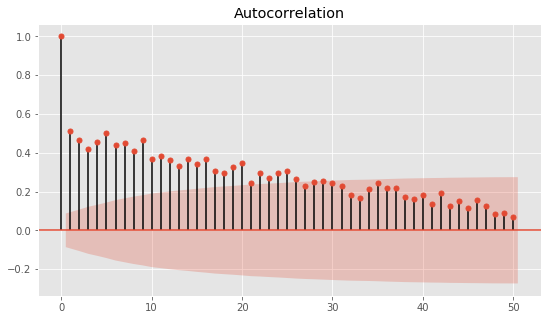

In [52]:
import statsmodels.tsa.api as smt
# Confidence intervals are drawn as a cone. 
# By default, this is set to a 95% confidence interval, 
# suggesting that correlation values outside of this code are very likely a correlation 
# and not a statistical fluke
acf = smt.graphics.plot_acf(lin_reg.resid, lags=50 , alpha=0.05)
acf.show()

##### 4.1.5. Multicollinearity

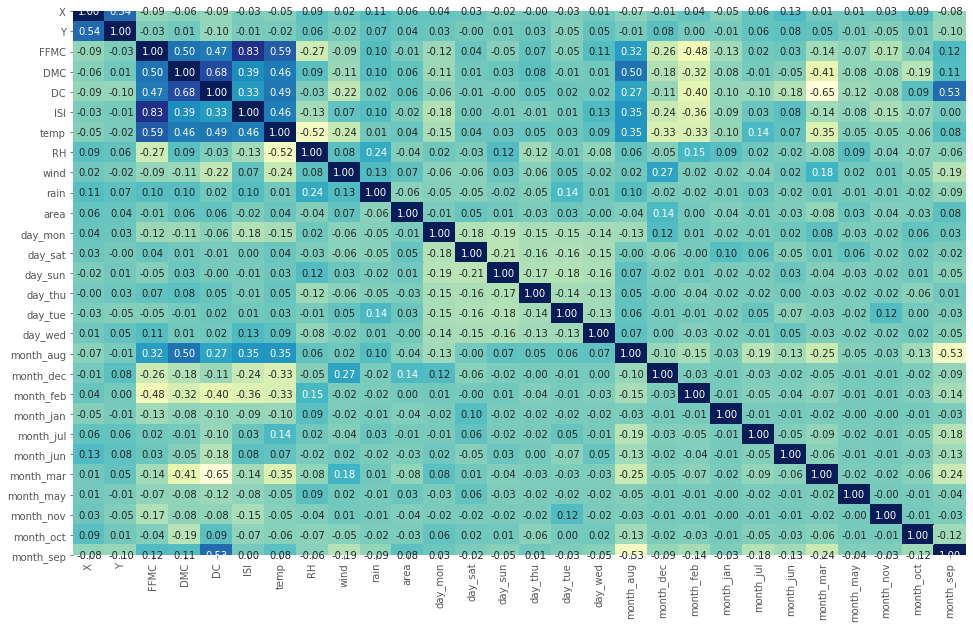

In [53]:
plt.figure(figsize =(16,10))

sns.heatmap(df.corr(),annot=True,cmap='YlGnBu',fmt=".2f",cbar=False)
plt.show()

In [54]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(X_constant.values, i) for i in range(X_constant.shape[1])]
pd.DataFrame({'vif': vif[1:]}, index=X.columns).sort_values(by="vif",ascending=False)

,vif
month_sep,53.307716
month_aug,43.939403
DC,26.792896
month_jul,8.378570
month_oct,7.681340
month_mar,6.694845
FFMC,5.629386
temp,4.535721
ISI,4.107793
DMC,3.978913


#### The above was the statistics approach to the problem; From here begins the ML approach.

In [55]:
lr = LinearRegression()
lr.fit(X, y)

print(f'Intercept: {lr.intercept_}')
print(f'R^2 score: {lr.score(X, y)}')
pd.DataFrame({"Coefficients": lr.coef_}, index=X.columns)

Intercept: 0.3192068355158235
R^2 score: 0.0769861533829217


,Coefficients
X,0.053161
Y,-0.011457
FFMC,-0.106058
DMC,0.004149
DC,-0.001854
ISI,-0.103922
temp,0.044297
RH,0.004063
wind,0.067775
rain,-0.927225


##### Improving Stats model

In [56]:
X = df.drop(columns=['area','damage_category'])
y = df['area']

In [57]:
def check_stats(X,y):
    vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print(pd.DataFrame({'vif': vif}, index=X.columns).sort_values(by="vif",ascending=False)[:10])
    lin_reg = sm.OLS(y,X).fit()
    print(lin_reg.summary())
check_stats(X,y)

                  vif
FFMC       202.334784
DC         159.585267
month_sep   77.976513
month_aug   67.081874
temp        53.012135
ISI         52.449380
RH          23.764931
Y           19.961996
DMC         15.417494
month_jul    8.764939
                                 OLS Regression Results                                
Dep. Variable:                   area   R-squared (uncentered):                   0.438
Model:                            OLS   Adj. R-squared (uncentered):              0.406
Method:                 Least Squares   F-statistic:                              13.92
Date:                Thu, 20 Feb 2020   Prob (F-statistic):                    7.32e-45
Time:                        16:33:27   Log-Likelihood:                         -874.85
No. Observations:                 510   AIC:                                      1804.
Df Residuals:                     483   BIC:                                      1918.
Df Model:                          27                 

Dropping columns to improve accuracy

In [58]:
X.drop(columns=['FFMC'],inplace=True)
# check_stats(X,y)

In [59]:
X.drop(columns=['Y'],inplace=True)
# check_stats(X,y)

In [60]:
X.drop(columns=['month_jul'],inplace=True)
# check_stats(X,y)

In [61]:
X.drop(columns=['day_thu'],inplace=True)
# check_stats(X,y)

In [62]:
X.drop(columns=['day_mon'],inplace=True)
# check_stats(X,y)

In [63]:
X.drop(columns=['month_aug'],inplace=True)
check_stats(X,y)

                 vif
DC         57.707223
ISI        38.292380
temp       27.680452
DMC        13.223716
RH         12.130774
wind        7.359276
X           5.267220
month_sep   3.915822
month_mar   2.741742
month_feb   1.631273
                                 OLS Regression Results                                
Dep. Variable:                   area   R-squared (uncentered):                   0.437
Model:                            OLS   Adj. R-squared (uncentered):              0.413
Method:                 Least Squares   F-statistic:                              18.07
Date:                Thu, 20 Feb 2020   Prob (F-statistic):                    2.20e-48
Time:                        16:33:54   Log-Likelihood:                         -875.21
No. Observations:                 510   AIC:                                      1792.
Df Residuals:                     489   BIC:                                      1881.
Df Model:                          21                            

##### Further improvement

##### Feature Selection Techniques
1. Pearson Correlation
2. Wrapper method
3. Embedded method

In [64]:
X_m, y_m = df_ml.drop(columns=[target]), df_ml[target]

### RFE

Out of 27 features, best number of features 1


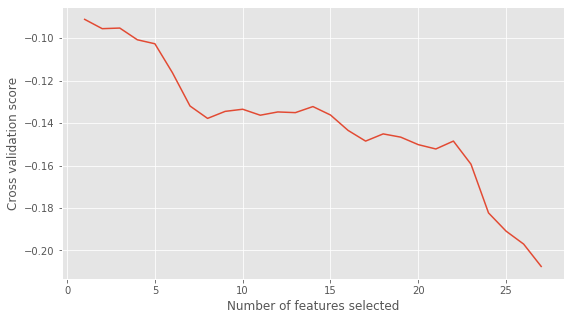

In [65]:
# RFECV is a variant with inbuilt Cross validation
model = LinearRegression()
selector = RFECV(model,cv=5)
selector = selector.fit(X_m, y_m)
print(f"Out of {len(X_m.columns)} features, best number of features {selector.n_features_}")
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(X_m.columns) + 1), selector.grid_scores_)
plt.show()

Out of 27 features, best number of features 19
['X' 'wind' 'rain' 'day_mon' 'day_sat' 'day_sun' 'day_thu' 'day_tue'
 'day_wed' 'month_aug' 'month_dec' 'month_feb' 'month_jan' 'month_jul'
 'month_jun' 'month_mar' 'month_may' 'month_nov' 'month_oct']


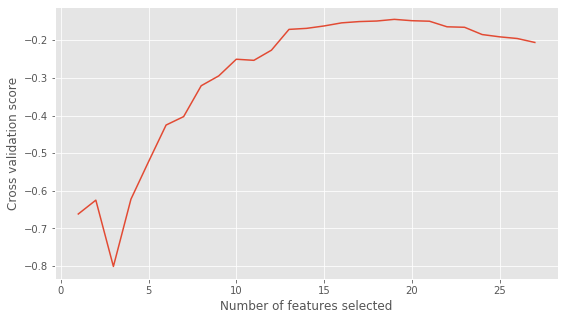

In [66]:
# In the stats method I found that the intercept was not relevant 
# Let's try that feature out in my ML model
model = LinearRegression(fit_intercept=False)
selector = RFECV(model,cv=5)
selector = selector.fit(X_m, y_m)
print(f"Out of {len(X_m.columns)} features, best number of features {selector.n_features_}")

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(X_m.columns) + 1), selector.grid_scores_)
print(X_m.columns[selector.support_].values)
plt.show()

##### Building model with the best features and checking the R2 score for the same

In [68]:
mask = selector.support_
print(f"Best features according to RFE {X_m.columns[mask].values}")

X_m1 = X_m.iloc[:,mask]
# We could have used train test split or cross validation strategies
# for scoring the model but in order to compare with the stats model 
# we will use the whole data
model1 = LinearRegression().fit(X_m1,y_m)
print(f"R2 Score: {model1.score(X_m1,y_m)}")

Best features according to RFE ['X' 'wind' 'rain' 'day_mon' 'day_sat' 'day_sun' 'day_thu' 'day_tue'
 'day_wed' 'month_aug' 'month_dec' 'month_feb' 'month_jan' 'month_jul'
 'month_jun' 'month_mar' 'month_may' 'month_nov' 'month_oct']
R2 Score: 0.05542824436801641


### Regularization

##### Ridge

In [72]:
# higher the alpha value, more restriction on the coefficients; 
# lower the alpha > more generalization, coefficients are barely
rr = RidgeCV(cv=5,fit_intercept=False) 
rr.fit(X_m, y_m)
rr.score(X_m,y_m)

0.06055519668815201

In [73]:
rr.alpha_

10.0

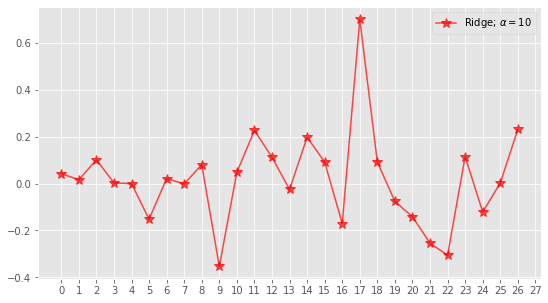

In [74]:
plt.plot(rr.coef_,alpha=0.7,marker='*',markersize=10,color='red',label=r'Ridge; $\alpha =10$') 
plt.grid(True)
plt.xticks(range(0,28,1))
plt.legend()
plt.show()

# 5. Credits

Andrej Angelovski 161529